In [131]:
%matplotlib inline

import io, os, sys, types, datetime, pickle, warnings

warnings.filterwarnings('ignore')

import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator

import numpy as np
from numpy.linalg import eig, inv

import math

from scipy import interpolate, spatial, stats

import seaborn as sns

import skimage.io as skiIo
from skimage import exposure, img_as_float, filters, morphology, transform

from sklearn import linear_model
from sklearn import metrics

In [2]:
""" ============== path settings =============="""

' ============== path settings =============='

In [3]:
env = 'Windows'
if(env == 'Windows'):
    module_path = 'W:\\2019_09_NSP_Extension\\code\\NSP_codes\\python_cluster\\helper_functions'
elif(env == 'Mac'):
    module_path = '/Users/lily/Lily/Academic/AW_Lab/code/python_cluster/helper_functions'

In [6]:
### import custom functions
if module_path not in sys.path:
    sys.path.append(module_path)
import data_quantification_settings as settings
import data_quantification_function_helper as my_help
import data_quantification_function_intensity_calculation as my_int
import data_quantification_function_parse_bundle as my_pb
import data_quantification_function_plotting as my_plot

Windows, Data_Output, Figure_Output, Fz_26hrs_s5r1_annotation.csv, 0, 1, 10, 5, 10, 10, 1
Windows, Data_Output, Figure_Output, Fz_26hrs_s5r1_annotation.csv, 0, 1, 10, 5, 10, 10, 1


In [10]:
paths = settings.paths
matching_info = settings.matching_info
analysis_params_general = settings.analysis_params_general

In [ ]:
"""============== main =============="""

In [ ]:
sns.set_style("dark")

In [12]:
"""Load data"""
### load summaries
summary_df = pd.read_csv(paths.annot_path)
image_list = summary_df.loc[:,'Image_Name'].unique()
ROI_list = summary_df.loc[:,'ROI_Name'].unique()


In [15]:
image_list, ROI_list

(array(['Fz80_26hrs_smp5_region1_sample.tif'], dtype=object),
 array(['Fz80_26hrs_smp5_region1_sample_ROI.csv'], dtype=object))

In [16]:
i_image = 0

In [19]:
### load other data
image_name = image_list[i_image]
roi_name = ROI_list[i_image]
roi_df = pd.read_csv(os.path.join(paths.roi_path, roi_name))
roi_df.rename(columns = {' ':'No'}, inplace = True)
annot_df = summary_df.groupby(['Image_Name']).get_group(image_list[i_image]).reset_index(drop = True)

In [20]:
%time image = img_as_float(skiIo.imread(os.path.join(paths.image_path, image_name)))
image_shape = (image.shape[0], image.shape[1], image.shape[2])
m2p_ratio = (summary_df.iloc[0]['imgX_pixel']/summary_df.iloc[0]['imgX_um'], summary_df.iloc[0]['imgY_pixel']/summary_df.iloc[0]['imgY_um'])
image_info = [image_name, image_shape, m2p_ratio]

Wall time: 6.98 s


In [112]:
""" Process annotation info"""
is_extended_target_list = False
annotation_type = annot_df.loc[0,'Annotation_type']
if(annotation_type == 3):
    bundles_df = get_bundles_info_v3(roi_df, annot_df, m2p_ratio[0], m2p_ratio[1], is_extended_target_list)
annot_bundles_df = bundles_df.dropna(axis=0, how='any', inplace = False)
annot_bundles_df.sort_index(inplace = True)

---annot_df---
1
8
12


In [115]:
""" Process images """
### number of channels
nChannels = min(image.shape)# number of channels of original image
num_norm_channels = len(matching_info.channel_cmap.keys()) # number of channels of normalized image

if(nChannels == 2):
    print("2 channels!")
    ### normalize channels
    image_norm = np.empty(image_shape + (num_norm_channels,), dtype=image[:,0,:,:].dtype, order='C')
    thr = np.zeros((2))
    
    # RFP_norm
    %time image_norm[:,:,:,0] = exposure.rescale_intensity(image[:,0,:,:], in_range = 'image', out_range='dtype')
    # GFP_norm
    %time image_norm[:,:,:,1] = exposure.rescale_intensity(image[:,1,:,:], in_range = 'image', out_range='dtype')    
    
    del image
        
elif(nChannels == 4):
    print("4 channels!")
    ### normalize channels
    image_norm = np.empty(image_shape + (num_norm_channels,), dtype=image[:,:,:,1].dtype, order='C')
    thr = np.zeros((2))
    
    # RFP_norm
    %time image_norm[:,:,:,0] = exposure.rescale_intensity(image[:,:,:,0], in_range = 'image', out_range='dtype')
    # GFP_norm
    %time image_norm[:,:,:,1] = exposure.rescale_intensity(image[:,:,:,1], in_range = 'image', out_range='dtype')    
    

4 channels!
Wall time: 4.66 s
Wall time: 3.64 s


In [116]:
""" Plot individual bundles """

' Plot individual bundles '

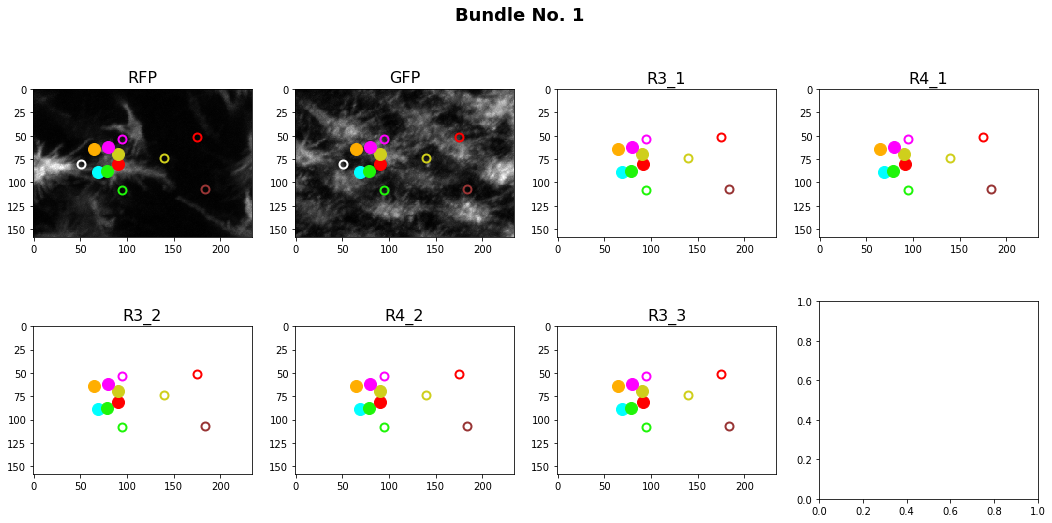

In [138]:
bundle_no = 1
plotSettings = False, False, False, True #isPlotR3Line, isPlotR4Line, isPlotR4s, isLabelOff
my_plot.plot_individual_bundles(bundle_no, bundles_df, image_norm, m2p_ratio[0], m2p_ratio[1], is_plot_r3_line = False, is_plot_r4_line = False, is_plot_r4 = False, is_label_off = True)
plt.show()

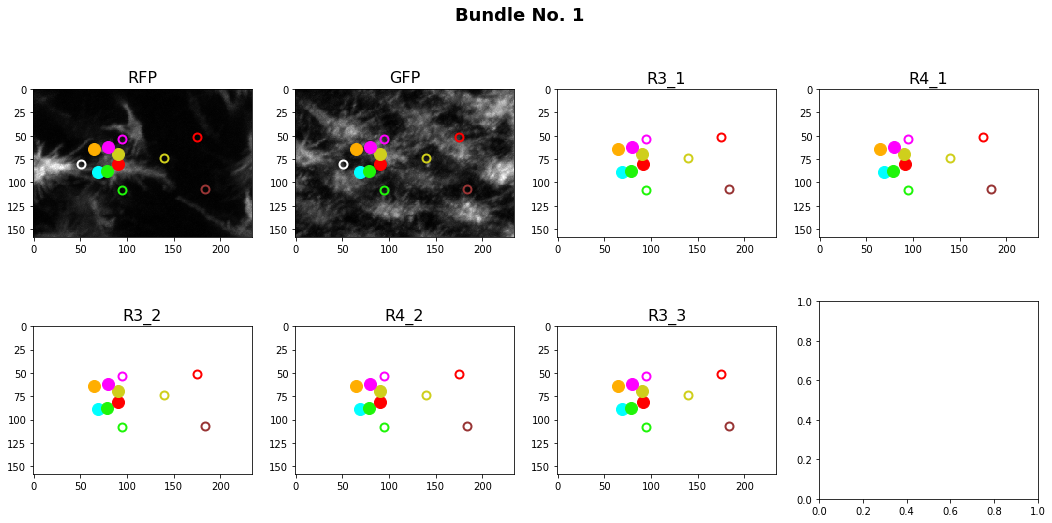

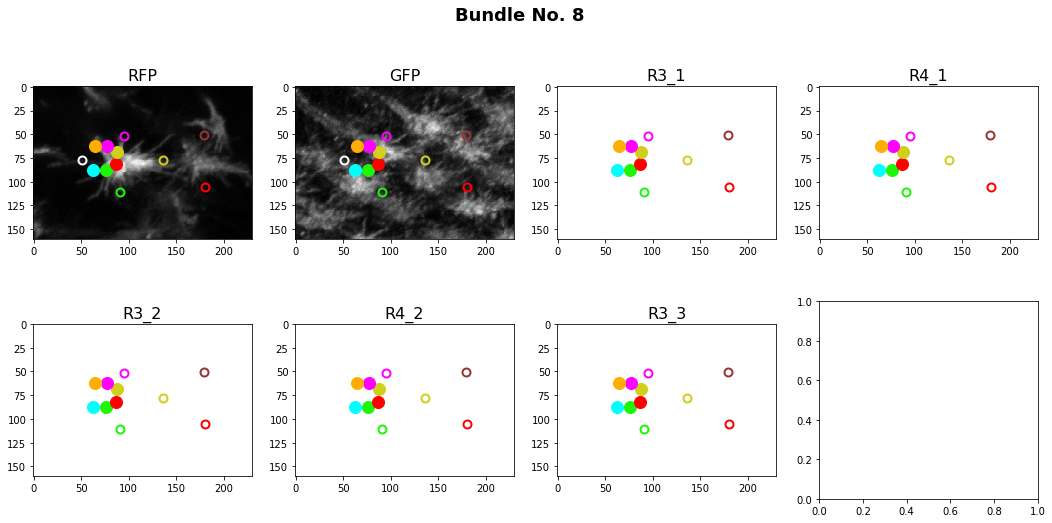

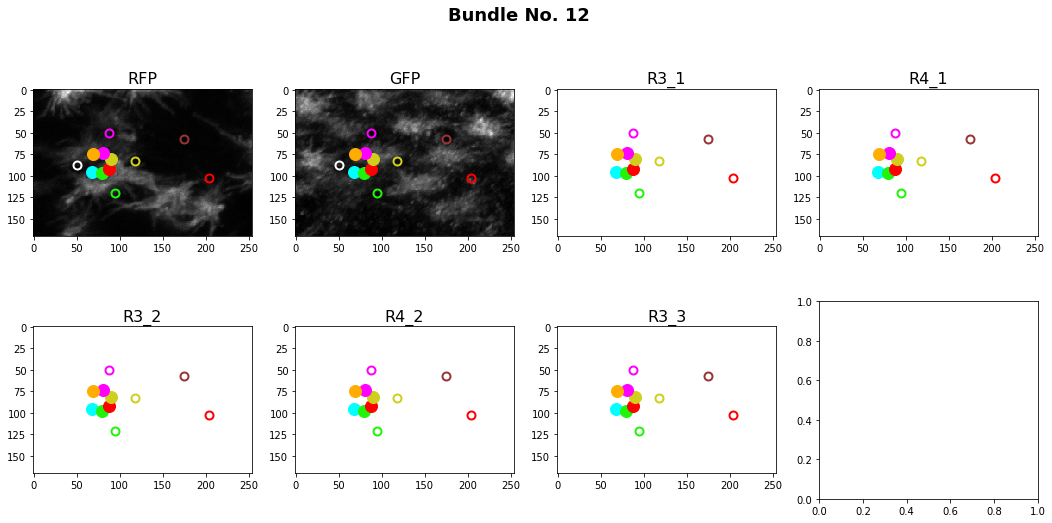

In [139]:
for ind, bundle_no in enumerate(annot_bundles_df.index):
    plotSettings = False, False, False, True #isPlotR3Line, isPlotR4Line, isPlotR4s, isLabelOff
    my_plot.plot_individual_bundles(bundle_no, bundles_df, image_norm, m2p_ratio[0], m2p_ratio[1], is_plot_r3_line = False, is_plot_r4_line = False, is_plot_r4 = False, is_label_off = True)
    plt.show()